# 주제 : LSTM을 활용해 주가 예측 모델 구현하기

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## Step 1. 데이터 불러오기 및 EDA

### 문제 01. 필요한 모듈 import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

### 문제 02. FinanceDataReader import

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [ ]:
!pip install finance-datareader

     |████████████████████████████████| 48 kB 2.2 MB/s 


In [ ]:
import FinanceDataReader as fdr

### 문제 03. 삼성전자 데이터 불러오기

In [ ]:
# fdr 라이브러리를 활용해 삼성전자 주가 데이터를 불러오세요.
# 대상 : 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930', '1996-11-05')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

### 문제 04. 삼성전자 데이터 EDA

In [ ]:
samsung.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-02-25,1561,1597,1490,1509,340690,NaN
1998-02-26,1577,1628,1528,1589,638701,0.053015
1998-02-27,1670,1715,1633,1716,849513,0.079924
1998-02-28,1815,1851,1799,1852,735349,0.079254
1998-03-02,1851,1906,1797,1834,570328,-0.009719


**미국 주식 데이터**도 가져올 수 있습니다.

### 문제 05. 애플 데이터 불러오기

In [ ]:
# fdr 라이브러리를 활용해 Apple(AAPL) 데이터를 불러오세요.
apple = fdr.DataReader('AAPL')

### 문제 06. 애플 데이터 EDA

In [ ]:
apple.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2022-04-07,172.14,171.16,173.36,169.85,74950000.0,0.0018
2022-04-08,170.09,171.78,171.78,169.20,76580000.0,-0.0119
2022-04-11,165.75,168.71,169.03,165.50,71550000.0,-0.0255
2022-04-12,167.66,168.02,169.87,166.64,78990000.0,0.0115
2022-04-13,170.40,167.39,171.04,166.77,70190000.0,0.0163


### 문제 07. 특정 시점(2017년) 이후 데이터 불러오기

In [ ]:
# Apple(AAPL), 2017년
apple = fdr.DataReader('AAPL', '2017')

In [ ]:
apple.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2017-01-03,29.04,28.95,29.08,28.69,115130000.0,0.0031
2017-01-04,29.00,28.96,29.13,28.94,84470000.0,-0.0014
2017-01-05,29.15,28.98,29.22,28.95,88770000.0,0.0052
2017-01-06,29.48,29.20,29.54,29.12,127010000.0,0.0113
2017-01-09,29.75,29.49,29.86,29.48,134250000.0,0.0092


### 문제 08. 날짜를 지정하여 특정 범위(40년간) 데이터 불러오기

In [ ]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1980-01-01', '2019-12-30')

In [ ]:
ford.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-03-18,1.83,1.83,1.85,1.82,3770000.0,-0.0108
1980-03-19,1.85,1.85,1.86,1.83,1560000.0,0.0109
1980-03-20,1.86,1.86,1.88,1.85,1450000.0,0.0054
1980-03-21,1.78,1.78,1.85,1.76,5020000.0,-0.0430
1980-03-24,1.71,1.71,1.75,1.66,3330000.0,-0.0393


### 문제 09. '금'과 '달러' 데이터도 가져올 수 있습니다. 두 데이터를 불러와 head를 출력해보세요.

*[GitHub 페이지 링크](https://github.com/FinanceData/FinanceDataReader) 참고

In [ ]:
# 금 선물 가격
gold = fdr.DataReader('ZG')
gold.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-01-02,575.5,562.5,577.0,558.0,7260.0,0.0785
1980-01-03,625.0,627.0,640.0,603.0,20750.0,0.0860
1980-01-04,603.6,609.5,621.0,573.0,2660.0,-0.0342
1980-01-07,627.0,629.0,635.0,611.0,3000.0,0.0388
1980-01-08,602.5,611.5,619.0,600.0,750.0,-0.0391


In [ ]:
# 달러 가격
usdkrw = fdr.DataReader('USD/KRW', '1995-01-01')
usdkrw.head()

,Close,Open,High,Low,Change
Date,,,,,
1995-01-02,788.50,788.50,788.50,788.50,0.0000
1995-01-03,788.65,788.05,788.85,787.55,0.0002
1995-01-04,789.95,788.65,790.05,788.45,0.0016
1995-01-05,789.90,789.80,790.20,789.30,-0.0001
1995-01-06,791.55,789.75,791.65,789.65,0.0021


### 문제 10. 삼성전자 데이터를 STOCK_CODE에 저장하고 인덱스를 확인해보세요

In [ ]:
# 문제 03과 코드는 동일합니다.
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [ ]:
# fdr 라이브러리를 활용해 삼성전자 데이터를 불러오세요 
stock = fdr.DataReader(STOCK_CODE)

In [ ]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-02-25,1561,1597,1490,1509,340690,NaN
1998-02-26,1577,1628,1528,1589,638701,0.053015
1998-02-27,1670,1715,1633,1716,849513,0.079924
1998-02-28,1815,1851,1799,1852,735349,0.079254
1998-03-02,1851,1906,1797,1834,570328,-0.009719


In [ ]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-04-08,68100,68300,67700,67800,15453191,-0.002941
2022-04-11,67800,68100,67400,67900,12263735,0.001475
2022-04-12,67600,67700,67000,67000,13924389,-0.013255
2022-04-13,67300,69000,67200,68700,17378619,0.025373
2022-04-14,68700,68700,67600,67800,8863104,-0.013100


In [ ]:
# 인덱스를 확인해보세요.
stock.index

DatetimeIndex(['1998-02-25', '1998-02-26', '1998-02-27', '1998-02-28',
               '1998-03-02', '1998-03-03', '1998-03-04', '1998-03-05',
               '1998-03-06', '1998-03-07',
               ...
               '2022-04-01', '2022-04-04', '2022-04-05', '2022-04-06',
               '2022-04-07', '2022-04-08', '2022-04-11', '2022-04-12',
               '2022-04-13', '2022-04-14'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

## Step 2. 시계열 데이터 시각화


### 문제 11. 인덱스가 `DatetimeIndex`로 정의되어 있다면, 연도, 월, 일을 쪼갤 수 있습니다. 데이터를 분리해주세요.

In [ ]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [ ]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1998-02-25,1561,1597,1490,1509,340690,NaN,1998,2,25
1998-02-26,1577,1628,1528,1589,638701,0.053015,1998,2,26
1998-02-27,1670,1715,1633,1716,849513,0.079924,1998,2,27
1998-02-28,1815,1851,1799,1852,735349,0.079254,1998,2,28
1998-03-02,1851,1906,1797,1834,570328,-0.009719,1998,3,2


### 문제 12. 연도별, 월별 피봇테이블을 각각 구현해보세요.

In [ ]:
stock.groupby(["Year", "Month"]).mean()

Open          High           Low         Close  \
Year Month                                                           
1998 2       1655.750000   1697.750000   1612.500000   1666.500000   
     3       1529.615385   1567.423077   1489.269231   1522.153846   
     4       1266.192308   1302.423077   1230.115385   1265.153846   
     5       1123.500000   1149.500000   1095.833333   1113.541667   
     6        814.375000    837.541667    786.291667    809.458333   
...                  ...           ...           ...           ...   
2021 12     77522.727273  78272.727273  76945.454545  77809.090909   
2022 1      76885.000000  77300.000000  75965.000000  76540.000000   
     2      73866.666667  74211.111111  73133.333333  73688.888889   
     3      70476.190476  70871.428571  70061.904762  70409.523810   
     4      68440.000000  68750.000000  68010.000000  68330.000000   

                  Volume    Change        Day  
Year Month                                     
1998 2      6.410632e+05  0.070731  26.500000  
     3      2.909726e+05 -0.012408  16.192308  
     4      2.999572e+05  0.002643  15.500000  
     5      3.651628e+05 -0.014984  16.875000  
     6      5.299693e+05 -0.005617  16.041667  
...                  ...       ...        ...  
2021 12     1.563206e+07  0.004349  15.681818  
2022 1      1.400936e+07 -0.003220  15.500000  
     2      1.295562e+07 -0.000864  15.277778  
     3      1.463966e+07 -0.001613  17.047619  
     4      1.395757e+07 -0.002560   8.100000  

[291 rows x 7 columns]

### 문제 13. matplotlib을 활용해 시간에 따른 주식 가격 시계열 그래프를 그려보세요.

Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


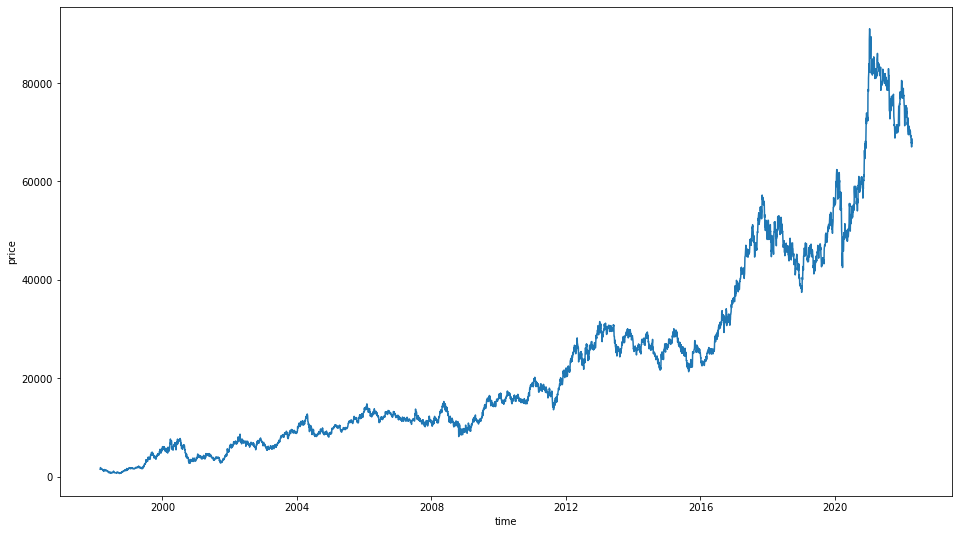

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(stock.index.to_pydatetime(), stock["Close"])
plt.xlabel("time")
plt.ylabel("price")


### 문제 14. subplots를 활용해 그래프 4개(2,2)를 동시에 그려보세요.

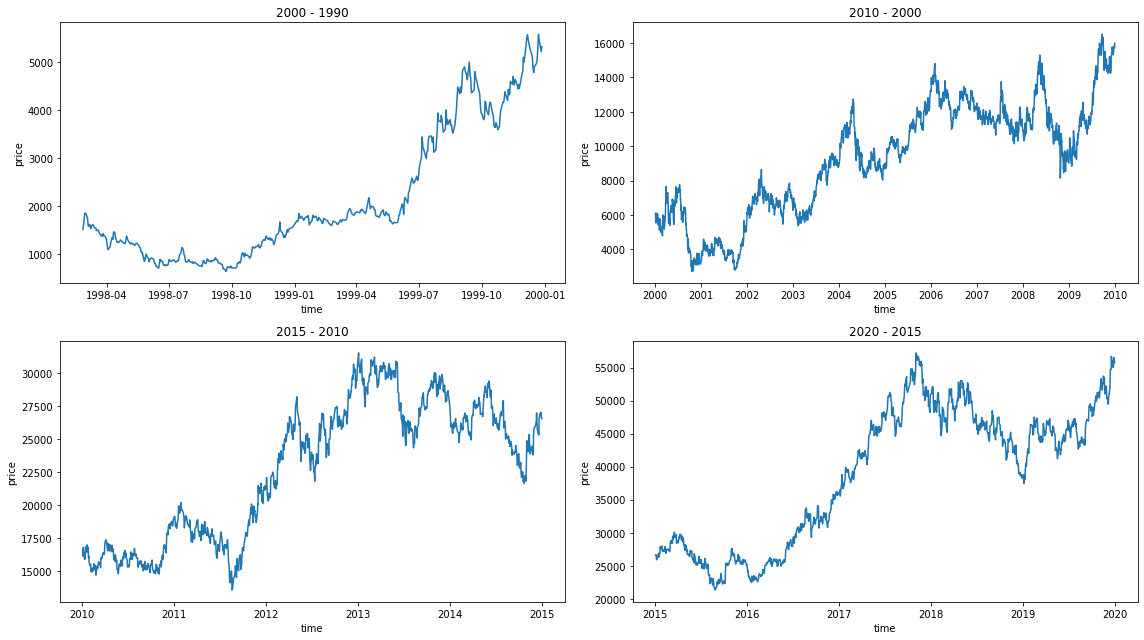

In [ ]:
# 1990~2000, 2000~2010, 2010~2015, 2015~2020
time_steps = [['1990', '2000'],
              ['2000', '2010'],
              ['2010', '2015'],
              ['2015', '2020']]

fig, axes = plt.subplots(2,2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(x=df.index, y=df["Close"], ax=ax)
    ax.set_title(f"{time_steps[i][1]} - {time_steps[i][0]}")
    ax.set_xlabel("time")
    ax.set_ylabel("price")
plt.tight_layout()
plt.show()

## Step 3. 시계열 데이터의 전처리

### 문제 15. MinMaxScaler를 활요해 데이터 전처리를 수행합니다.

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [ ]:
# 아래 코드는 그대로 실행해주세요.
df = pd.DataFrame(scaled, columns=scale_cols)

### 문제 16. 모델 학습을 위해 train 데이터와 test 데이터로 분할해주세요.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Close 컬럼이 예측할 데이터입니다.
# test_size는 0.2, random_state는 0으로 지정해주세요.
# shuffle을 수행하지 않습니다.
x_train, x_test, y_train, y_test = train_test_split(df.drop("Close", axis=1), df["Close"], test_size=0.2, random_state=0, shuffle=False)

### 문제 17. train 데이터와 test 데이터의 shape을 각각 살펴봅니다.

In [ ]:
x_train.shape, x_test.shape

((4800, 4), (1200, 4))

In [ ]:
y_train.shape, y_test.shape

((4800,), (1200,))

In [ ]:
x_train

,Open,High,Low,Volume
0,0.017287,0.016498,0.016648,0.003773
1,0.017464,0.016818,0.017073,0.007073
2,0.018494,0.017717,0.018246,0.009407
3,0.020100,0.019122,0.020101,0.008143
4,0.020498,0.019690,0.020078,0.006315
...,...,...,...,...
4795,0.498782,0.468802,0.500112,0.003907
4796,0.502769,0.470868,0.501676,0.002792
4797,0.496788,0.467975,0.500559,0.001921
4798,0.500111,0.471901,0.500559,0.002889


### 문제 18. TensroFlow Dataset을 활용해 시퀀스 데이터셋을 함수로 구현해주세요

In [ ]:
import tensorflow as tf

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

## Step 4. 모델 구현하기

### 문제 19. Hyperparameter를 정의하고 데이터에 적용해주세요.

In [ ]:
# 아래 코드는 그대로 실행해주세요.
WINDOW_SIZE=20
BATCH_SIZE=32

In [ ]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
# WINDOW_SIZE와 BATCH_SIZE를 각 데이터셋에 적용해주세요.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다. 그대로 실행해보고, 데이터의 shape을 살펴보세요.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


### 문제 20. Sequential 모델을 구현합니다. 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성합니다. filters는 32로, kernel_size는 5로 지정해주세요.
    Conv1D(32, kernel_size=5, padding="same", activation="relu", input_shape=(WINDOW_SIZE, 1)),
    # LSTM과 Dense 레이어를 사용해주세요. 필요한 경우 활성함수는 relu로 지정합니다.
    LSTM(16),
    Dense(16, activation="relu"),
    Dense(1)
])

### 문제 21. 모델을 Compile합니다. loss는 Huber 함수를 사용하고 optimizer는 Adam을 사용해주세요.

In [ ]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.005)
model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

In [ ]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor="val_loss", patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, save_best_only=True, save_weights_only=True, monitor="val_loss", verbose=True)

In [ ]:
# callbacks로 앞에서 구현한 earlystopping과 checkpoint를 지정해주세요.
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    150/Unknown - 28s 113ms/step - loss: 5.3103e-05 - mse: 1.0621e-04
Epoch 1: val_loss improved from inf to 0.00076, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 30s 125ms/step - loss: 5.3103e-05 - mse: 1.0621e-04 - val_loss: 7.5737e-04 - val_mse: 0.0015
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 2.1256e-05 - mse: 4.2511e-05
Epoch 2: val_loss improved from 0.00076 to 0.00029, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 25s 164ms/step - loss: 2.1256e-05 - mse: 4.2511e-05 - val_loss: 2.8997e-04 - val_mse: 5.7995e-04
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 1.7887e-05 - mse: 3.5774e-05
Epoch 3: val_loss improved from 0.00029 to 0.00027, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 27s 181ms/step - loss: 1.7887e-05 - mse: 3.5774e-05 - val_loss: 2.7149e-04 - val_mse: 5.4297e-04
Epoch 4/50
150/150 [===================

## Step 5. 모델을 활용한 예측 및 결과 시각화

### 문제 24. 저장한 ModelCheckpoint 를 불러옵니다.

In [ ]:
model.load_weights(filename)

### 문제 25. `test_data`를 활용하여 예측을 수행합니다.

In [ ]:
pred = model.predict(test_data)

In [ ]:
pred.shape

(1180, 1)

### 문제 26. matplotlib을 활용해 예측 데이터를 시각화해주세요.

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

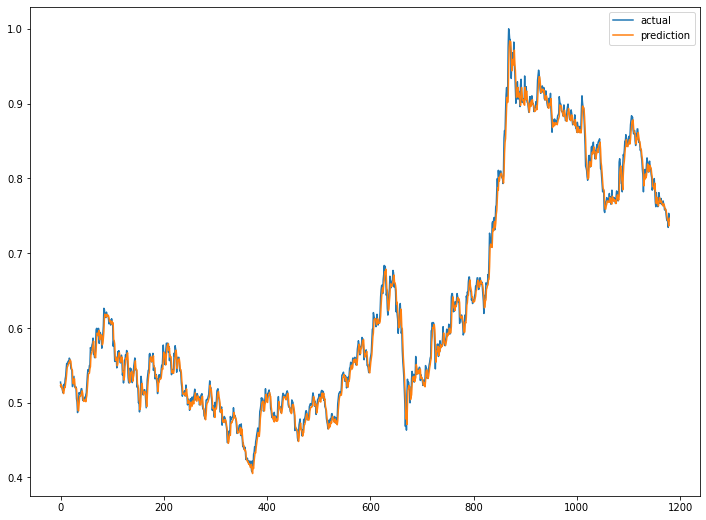

In [ ]:
# 20일치의 데이터로 21일치를 예측하므로 test_data 사용시 이전 20일은 예측하지 않습니다.
# 따라서 y_test 데이터에 [20:]로 슬라이싱해주세요.
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test[20:]), label="actual")
plt.plot(pred, label="prediction")
plt.legend()
plt.show()